# Marginalizing a Systematic: Hubble’s Law and the Distance to a Galaxy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
from scipy.integrate import quad as quad

### a) and b) 
The PDF for an exactly defined Hubble constant is shown below and has the form of a Gaussian. 

Upper boud: 413.40
Lower boud: 386.60
Calculated confidence interval: 0.68


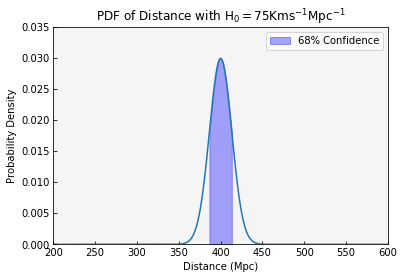

In [2]:
def marginal_H(d, v_m=30000, sigma_v=1000,  H_CONST=75):
    """
    PDF for distance given an exact value for H.

    Parameters
    ----------
    d : float
        Distance in Mpc
    v_m : float
        Measured recessional velocity in Km/s
    sigma_v : float
        Error in the recessional velocity
    H_CONST : float
        The Hubble constant in Km/s/Mpc
    
    Returns
    -------
    The probability at a given distance
    """
    const = np.sqrt(2*np.pi) * sigma_v * 800
    const = 60000 / const
    return const * np.exp(-0.5 * ((v_m - H_CONST * d) / sigma_v)**2)


v_m = 30000
sigma_v = 1000
H = 75

distance = np.linspace(0, 800, 8000)
high, low = 401, 399
int_high, int_low = 0, 0
confidence = 0

# Find bounds of confidence interval by integrating out
while confidence < 0.68:
    int_high = quad(marginal_H, 400, high, (v_m, sigma_v, H))[0]
    int_low = quad(marginal_H, low, 400, (v_m, sigma_v, H))[0]
    confidence = int_high + int_low
    high += 0.1
    low -= 0.1
print("Upper boud: {:.2f}".format(high))
print("Lower boud: {:.2f}".format(low))
print("Calculated confidence interval: {:.2f}".format(confidence))

section = np.linspace(low, high, 50)
plt.plot(distance, marginal_H(distance, 30000, 1000, 75))
plt.xlim(200, 600)
plt.fill_between(section, marginal_H(section), alpha=0.35, color='b')
plt.xlabel("Distance (Mpc)")
plt.ylabel("Probability Density")
plt.ylim(0, 0.035)
plt.gca().tick_params(direction='in', axis='both')
plt.gca().set_facecolor('whitesmoke')
blue_patch = mpatches.Patch(color='b', alpha=0.35, label='68% Confidence')
plt.legend(handles=[blue_patch])
plt.title(r"PDF of Distance with $\mathregular{H_{0} = 75 Km s^{-1} Mpc^{-1}}$")
plt.show()

### c) and d)
Here, we allow the Hubble constant to be uniform distributed from $50$ to $90 Km s^{-1} Mpc^{-1}$.

Upper bound: 507.86
Lower bound: 338.14


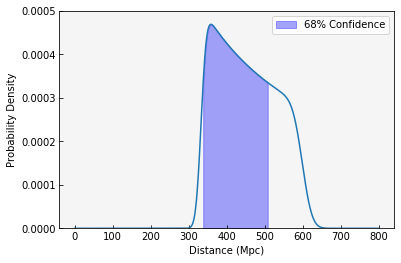

In [3]:
def marginal_H_uniform(H, d, v_m, sigma_v):
    """
    PDF for distance given a give value of H.
    Normalized for the uniform distribution.

    Parameters
    ----------
    H : float
        The Hubble constant in Km/s/Mpc
    d : float
        Distance in Mpc
    v_m : float
        Measured recessional velocity in Km/s
    sigma_v : float
        Error in the recessional velocity
    
    Returns
    -------
        Returns the probability 
    """
    
    const = 1 / (np.sqrt(2*np.pi)*sigma_v)
    const = const * (1 / 40) * (1 / 800) * 5444.83285
    return const * np.exp(-0.5 * ((v_m - H * d) / sigma_v)**2)

def confidence_calc(pdf):
    """"
     The 68% confidence interval is calculated using
    the following algorithm:
        1. Sort probabilites from highest to lowest
        2. Sum probabilities to desired confidence
           while also keep track of the corresponding
           distances for each probability
        3. Sort resulting distances once the 
           confidence is reached
        4. The confidence interval is defined
           by the lowest and highest distances
           
    Paramters
    ---------
    pdf : array
        An array of probabilities
        
    Returns
    -------
    low_idx, high idx : float
        Indices that specify the lowest
        and highest distances that bound
        the 68% confidence interval
    conf_dist : list
        List of distances with in the
        confidence interval
            
    """
    
    # Sort pdf in descending order with corresponding distances
    ind = np.argsort(-pdf)
    distance_sorted = distance[ind]
    pdf_sorted = pdf[ind]

    # Sum probabilities and keep track of distances
    confidence = 0
    conf_dist = []
    for p, d in zip(pdf_sorted, distance_sorted):
        if confidence < 0.68:
            confidence += p
            conf_dist.append(d)
        else:
            break

    # Confidence interval is corresponding lowest and highest distances
    distance_conf_sort = sorted(conf_dist)
    low_conf, high_conf = distance_conf_sort[0], distance_conf_sort[-1]
    low_idx, high_idx = np.where(distance == low_conf)[0][0], np.where(distance == high_conf)[0][0]
    print("Upper bound: {:.2f}".format(high_conf))
    print("Lower bound: {:.2f}".format(low_conf))
    return low_idx, high_idx, conf_dist

def distribution_plot(f, H_low, H_high, distance, *args):
    """
    Function that creates PDF and plots confidence
    interval. Note that this function does NOT 
    currently work with Gaussian distributed 
    Hubble constants. It does work for the uniform
    and Jeffreys prior. 

    Parameters
    ----------

    Returns
    -------
    """
    # Build PDF with uniformly distributed H
    pdf = np.zeros_like(distance) 

    for i, d in enumerate(distance):
        result = quad(f, H_low, H_high, args=(d, args[0], args[1]))[0]
        pdf[i] = result
    
    # Unpack indicies that specify low and high distance in conf interval
    low_idx, high_idx, conf_dist = confidence_calc(pdf)
    
    # Plot PDF with confidence interval
    plt.plot(distance, pdf)
    plt.xlabel("Distance (Mpc)")
    plt.ylabel("Probability Density")
    plt.ylim(0, 0.0005)
    plt.fill_between(distance[low_idx:high_idx], pdf[low_idx:high_idx], alpha=0.35, color='b')
    plt.gca().tick_params(direction='in', axis='both')
    plt.gca().set_facecolor('whitesmoke')
    blue_patch = mpatches.Patch(color='b', alpha=0.35, label='68% Confidence')
    plt.legend(handles=[blue_patch])
    plt.show()


# Define parameters
v_m = 30000
sigma_v = 1000
H_mean1, H_mean2 = 67.66, 74.03
sigma_H1, sigma_H2 = 0.42, 1.42
distance = np.linspace(0, 800, 8000)
norm_67 = 5413.809228548235
norm_74 = 5921.7166242098865

distribution_plot(marginal_H_uniform, 50, 90, distance, v_m, sigma_v)

### e) and f) 
The Hubble constant covers the same range as in part d) but this time using a Jeffreys prior instead.

Upper bound: 544.57
Lower bound: 363.45


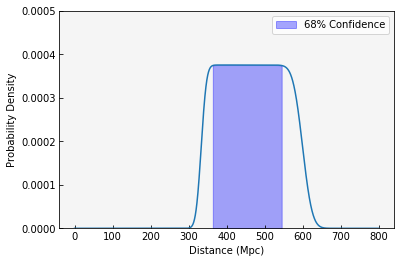

In [24]:
def marginal_H_jeffrey(H, d, v_m, sigma_v):
    """
    PDF for distance given a value of the
    Hubble constant. Normalized for the
    Jeffreys distribution.

    Parameters
    ----------
    H : float
        The Hubble constant in Km/s/Mpc
    d : float
        Distance in Mpc
    v_m : float
        Measured recessional velocity in Km/s
    sigma_v : float
        Error in the recessional velocity
    
    Returns
    -------
        Returns the probability 
    """
        
    const = 1 / (np.sqrt(2*np.pi)*sigma_v)
    const = const * (1 / np.log(9/5)) * (1 / 800) * 5290.74156
    return const * (1/H) * np.exp(-0.5 * ((v_m - H * d) / sigma_v)**2)

distribution_plot(marginal_H_jeffrey, 50, 90, distance, v_m, sigma_v)

### f) and g)
The Hubble constant now has a Gaussian distribution. Here we compare two different best estimates from separate studies to see if their PDFs overlap.

Upper bound: 458.26
Lower bound: 428.45
Upper bound: 420.75
Lower bound: 389.75


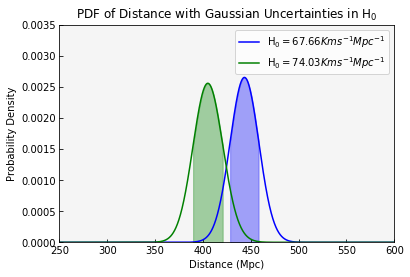

In [25]:
def marginal_H_guassian(H, d, v_m, sigma_v, H_mean, sigma_H, norm):
    """
    PDF for distance given a value of the
    Hubble constant. 

    Parameters
    ----------
    H : float
        The Hubble constant in Km/s/Mpc
    d : float
        Distance in Mpc
    H_mean : float
        The best estimate of the Hubble constant
        from measurement
    sigma_H : float
        Error in Hubble constant measurement
    v_m : float
        Measured recessional velocity in Km/s
    sigma_v : float
        Error in the recessional velocity
    norm : float
        Normalization constant for the distribution
    
    Returns
    -------
        Returns the probability 
    """
    
    const = 800 * 2 * np.pi * sigma_H * sigma_v
    const = (1 / const) * norm
    exp1 = (v_m - H * d) / sigma_v
    exp2 = (H - H_mean) / sigma_H
    return const * np.exp(-0.5 * (exp1**2 + exp2**2))

# Build PDFs
pdf_dist_67 = np.zeros_like(distance)
pdf_dist_74 = np.zeros_like(distance)

for i, d in enumerate(distance):
    result_67 = quad(marginal_H_guassian, 50, 90,
                 (d, v_m, sigma_v, H_mean1, sigma_H1, norm_67))[0]
    result_74 = quad(marginal_H_guassian, 50, 90,
                 (d, v_m, sigma_v, H_mean2, sigma_H2, norm_74))[0]
    pdf_dist_67[i] = result_67
    pdf_dist_74[i] = result_74

# Find indices for smallest and largest distances that bound 68% conidence
low_idx_67, high_idx_67, conf_dist_67 = confidence_calc(pdf_dist_67)
low_idx_74, high_idx_74, conf_dist_74 = confidence_calc(pdf_dist_74)

plt.plot(distance, pdf_dist_67, color='b', label='$\mathregular{H_{0}} = 67.66 Kms^{-1}Mpc^{-1}$')
plt.plot(distance, pdf_dist_74, color='g', label='$\mathregular{H_{0}} = 74.03 Kms^{-1}Mpc^{-1}$')
plt.fill_between(distance[low_idx_67:high_idx_67], pdf_dist_67[low_idx_67:high_idx_67], alpha=0.35, color='b')
plt.fill_between(distance[low_idx_74:high_idx_74], pdf_dist_74[low_idx_74:high_idx_74], alpha=0.35, color='g')
plt.xlabel("Distance (Mpc)")
plt.ylabel("Probability Density")
plt.title(r"PDF of Distance with Gaussian Uncertainties in $\mathregular{H_{0}}$ ")
plt.xlim(250, 600)
plt.ylim(0, 0.0035)
plt.gca().tick_params(direction='in', axis='both')
plt.gca().set_facecolor('whitesmoke')
plt.legend(loc='upper right')
plt.show()

From the plot above, it does not appear that the PDFs overlap at the 68% confidence interval.